In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_29102020_tracker.pkl
187 187
Smoothing 7358 recovered between 2020-05-28 and 2020-04-26 (32) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-26 (49) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-26 (50) days in a weighted-mag manner
Smoothing 2432 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5900 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner

splitting data ..
splitting data ..
          date        state district   total  active  recovered  deceased  \
0   2020-04-26  Maharashtra   Mumbai    5407    4562        641       204   
1   2020-04-27  Maharashtra   Mumbai    5780    4794        763       223   
2   2020-04-28  Maharashtra   Mumbai    6177    5017        908       252   
3

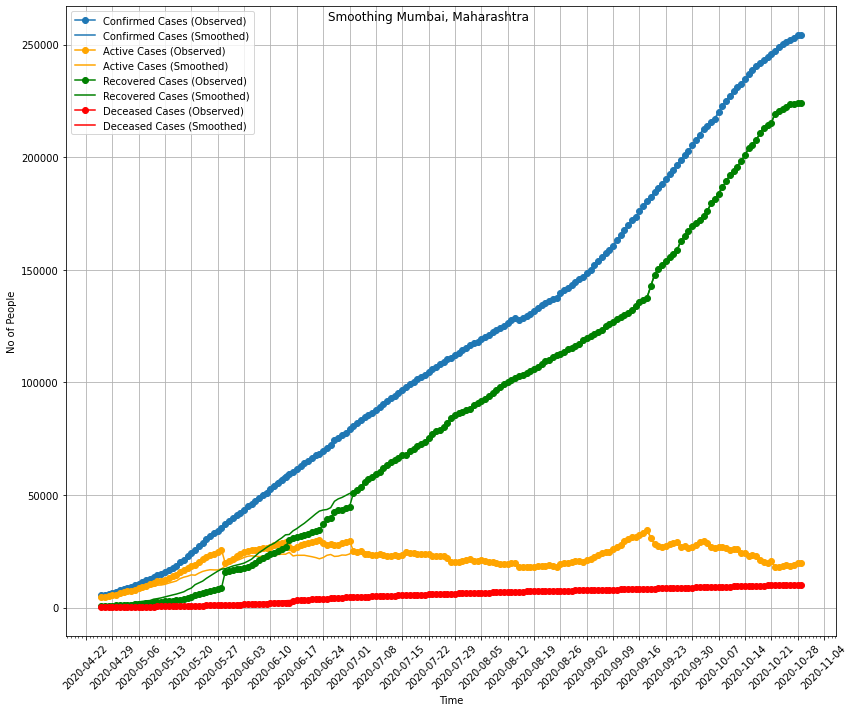

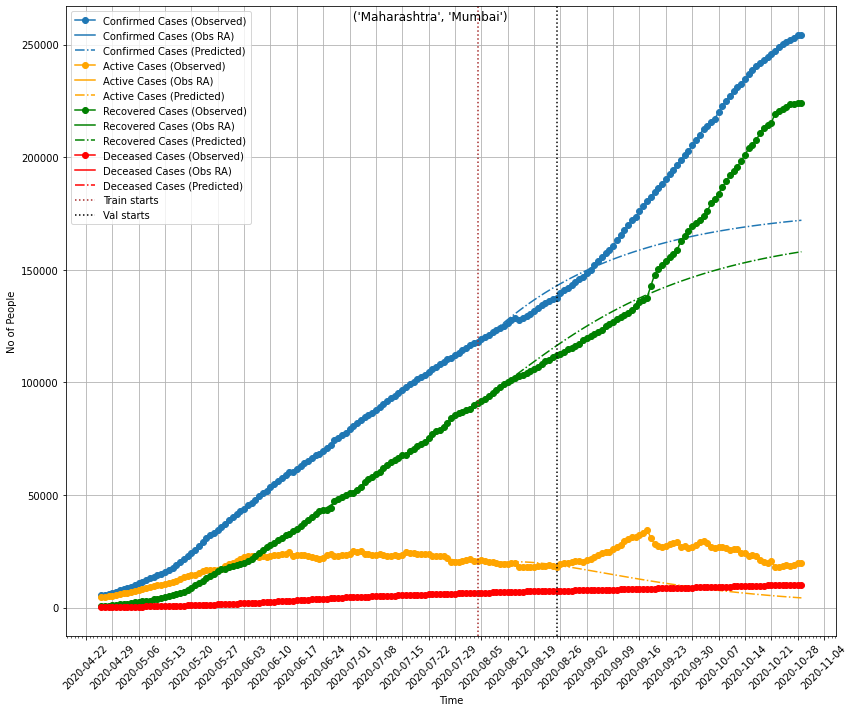

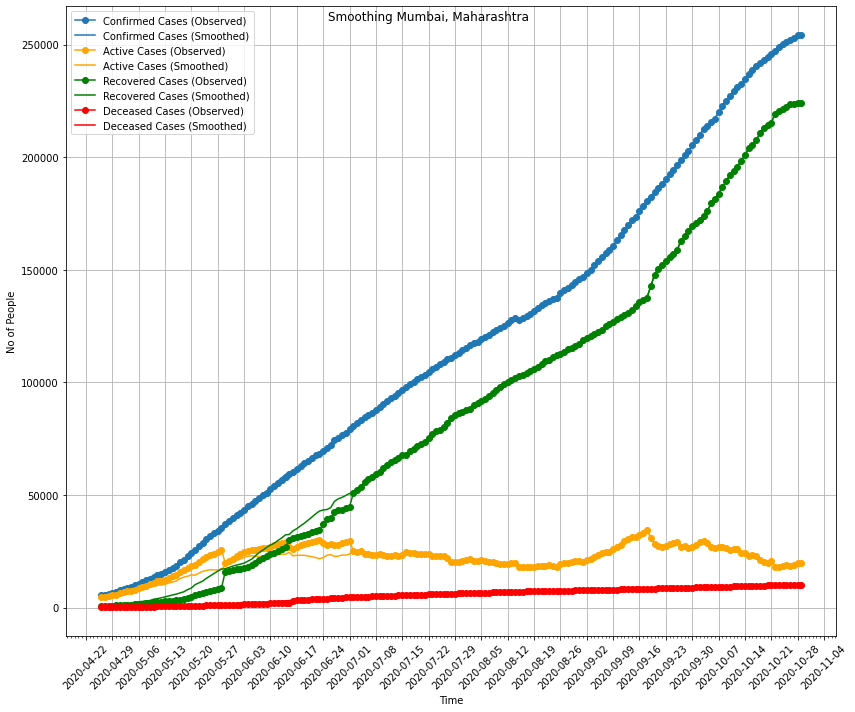

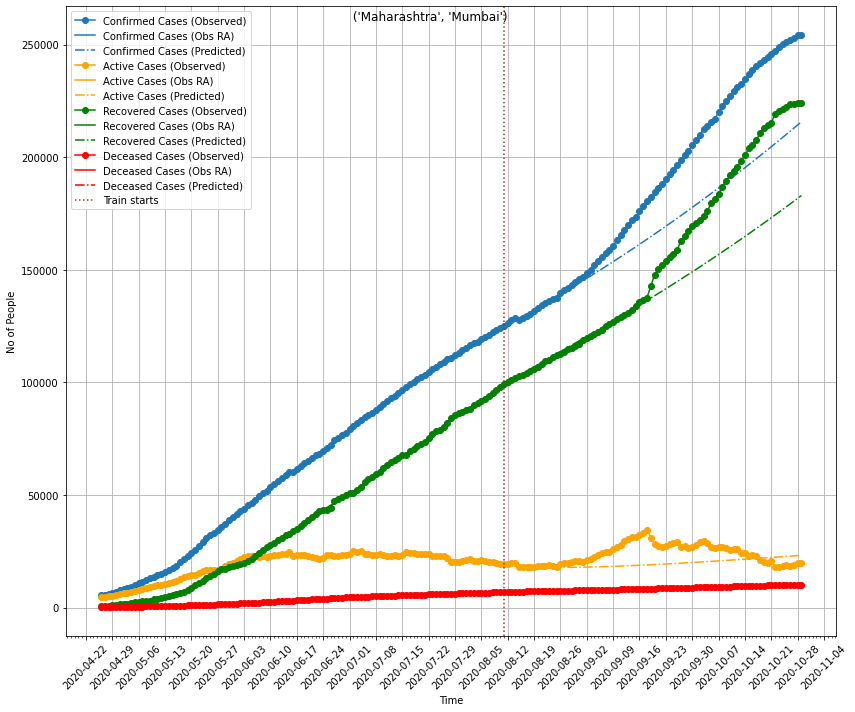

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.5220894564293055,
 'I_hosp_ratio': 0.08349064216843687,
 'P_fatal': 0.04422908152822747,
 'T_inc': 4.395507957893684,
 'T_inf': 3.796116376621151,
 'T_recov': 15.703929739026627,
 'T_recov_fatal': 16.95097181597891,
 'lockdown_R0': 0.7995090924683965}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.26675480769014837,
 'I_hosp_ratio': 0.10539614531926816,
 'P_fatal': 0.025905801861969984,
 'T_inc': 4.578851816907609,
 'T_inf': 3.3433875930693473,
 'T_recov': 18.281717685180247,
 'T_recov_fatal': 6.618588184320214,
 'lockdown_R0': 1.063146112553409}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

train      val
total       2.00892  2.54522
active      5.62992  9.43261
recovered    1.6089  4.41294
deceased   0.802705  3.48152

### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

train
total      0.497646
active      4.94862
recovered  0.563277
deceased   0.649203

## Sensitivity Plot

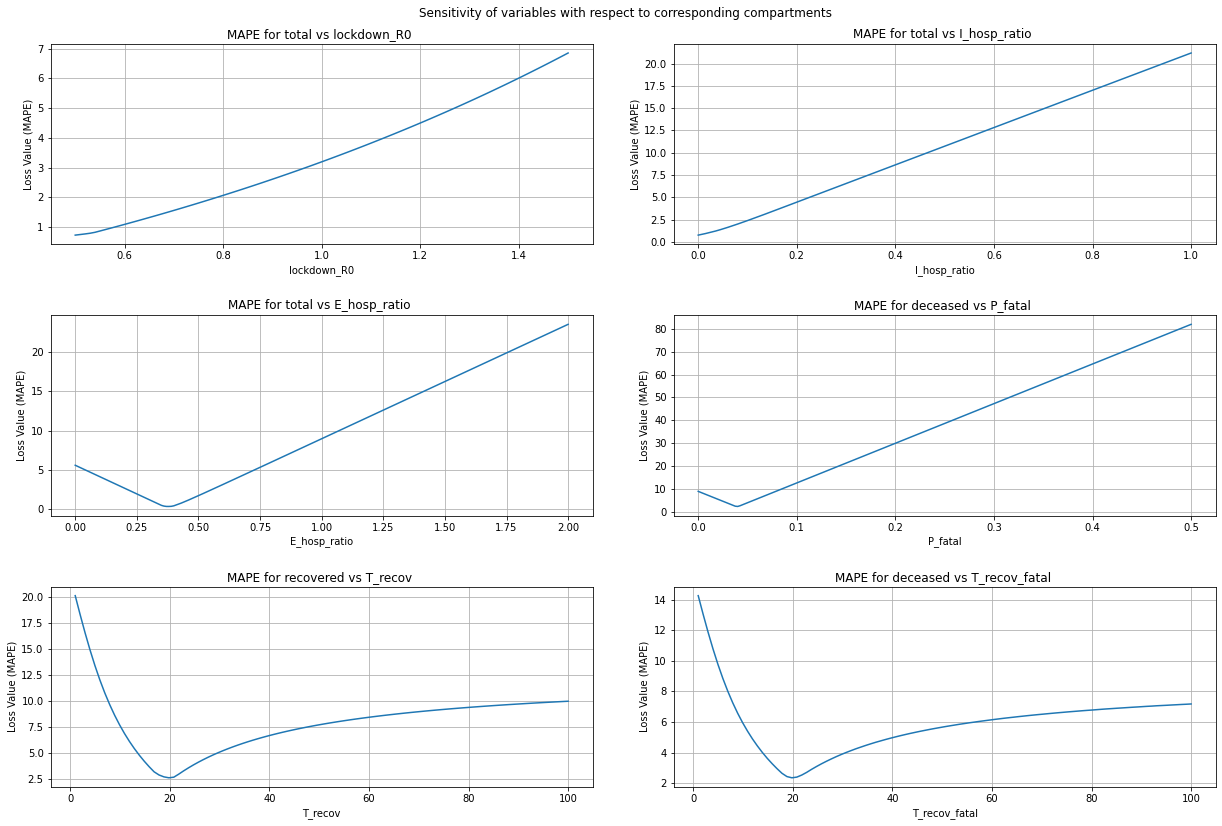

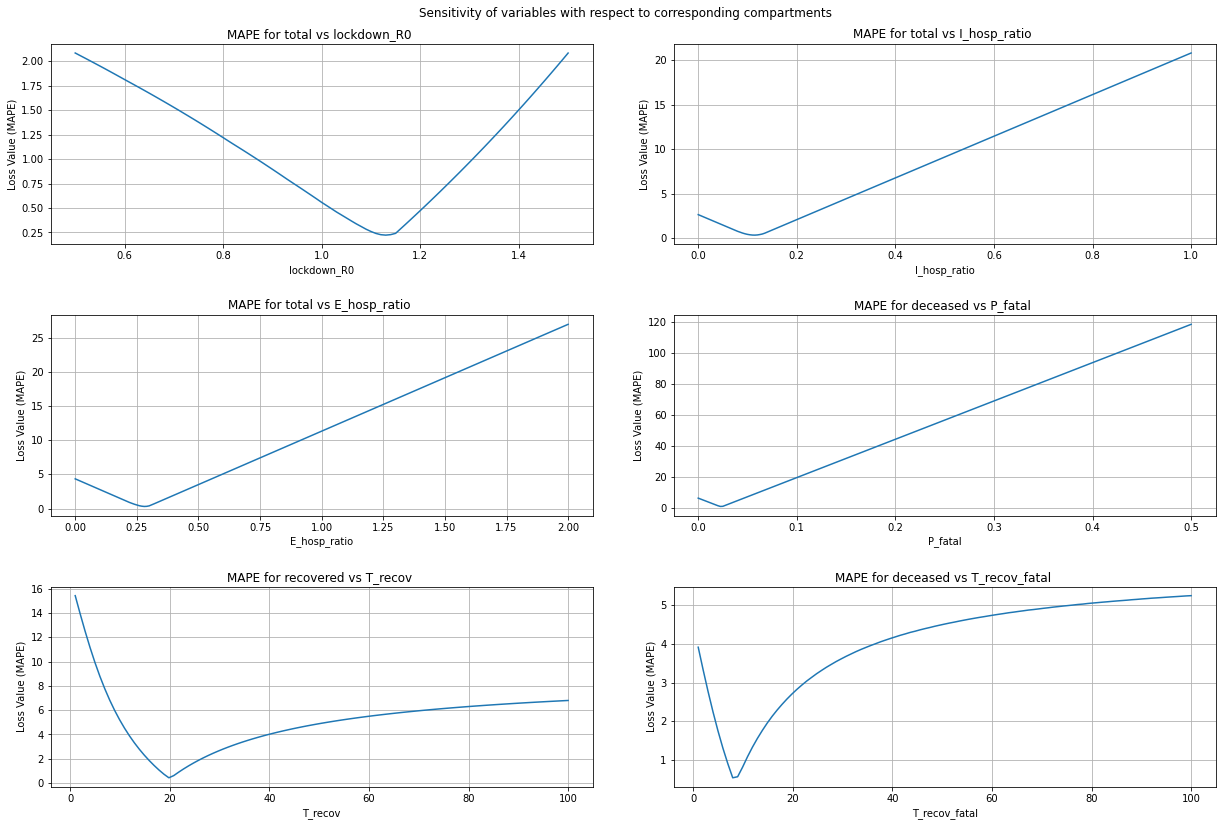

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [12]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


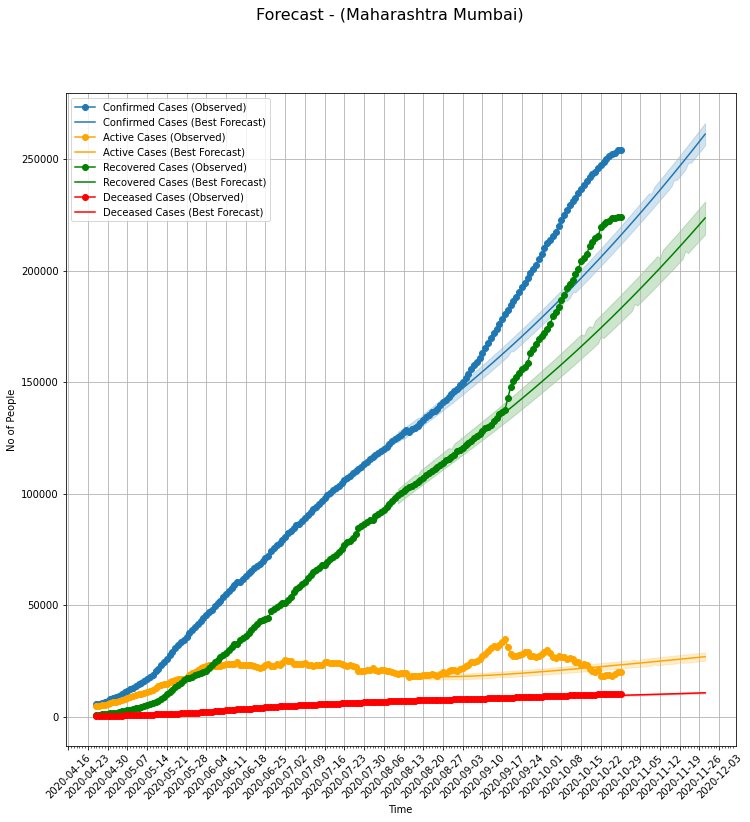

In [13]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [14]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

7it [00:00, 69.17it/s]getting forecasts ..
100it [00:01, 82.47it/s]


In [15]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 101.71it/s]getting forecasts ..
100it [00:01, 73.34it/s]


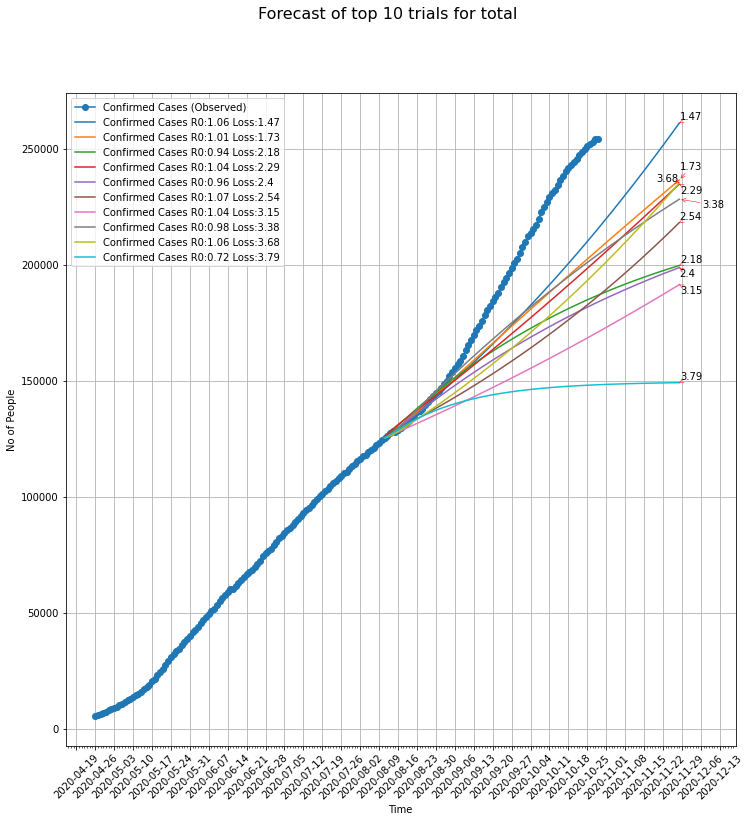

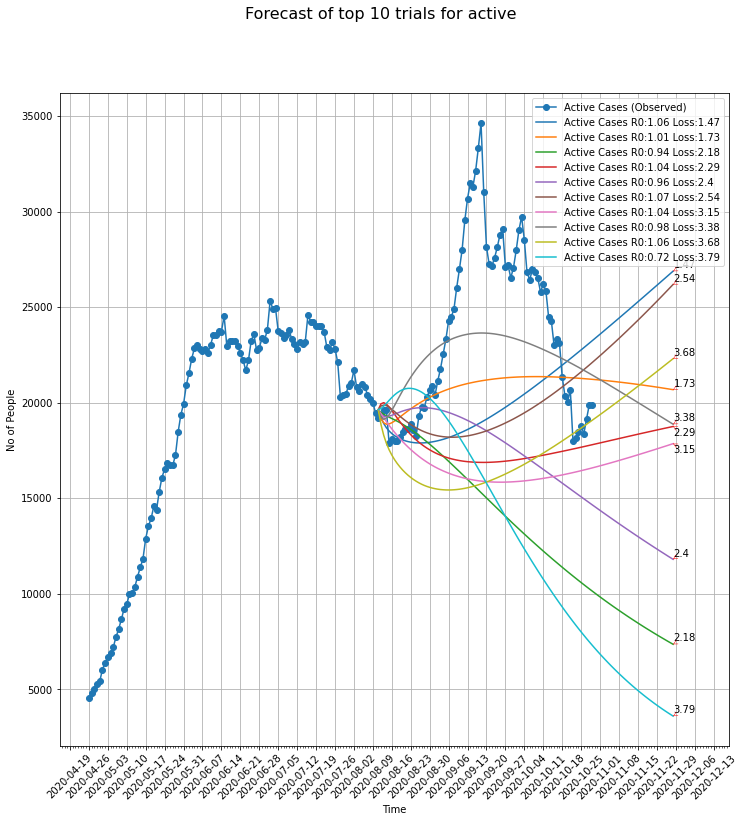

In [16]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [17]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [18]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:05<00:00, 16.73trial/s, best loss: 3.9012055508515098]


In [19]:
uncertainty.beta_loss

{'active': 10.961099732926716,
 'recovered': 2.4442953864356807,
 'deceased': 1.453900030538916,
 'total': 0.7455270535047264}

In [20]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [21]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

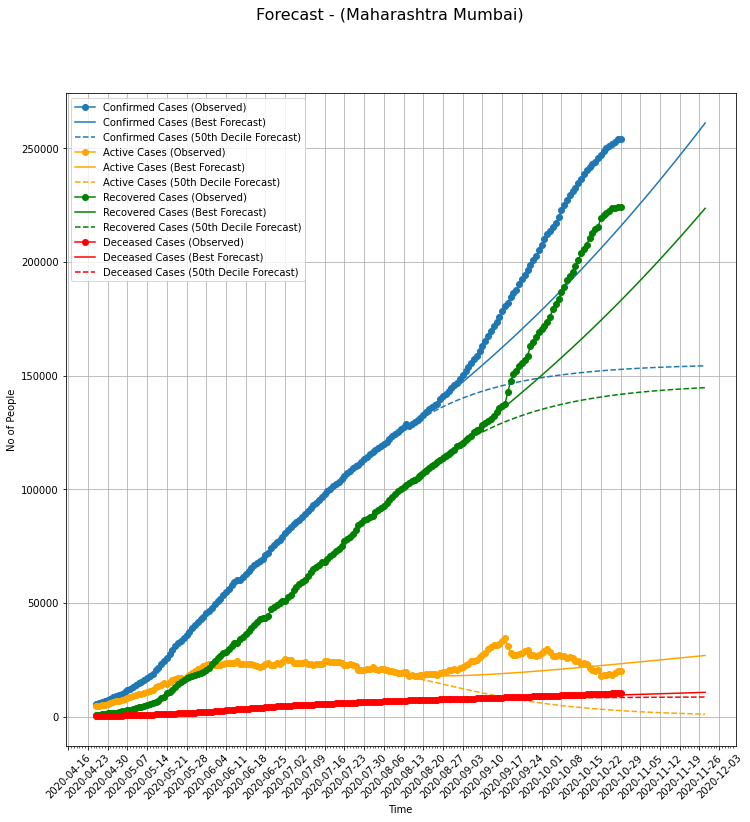

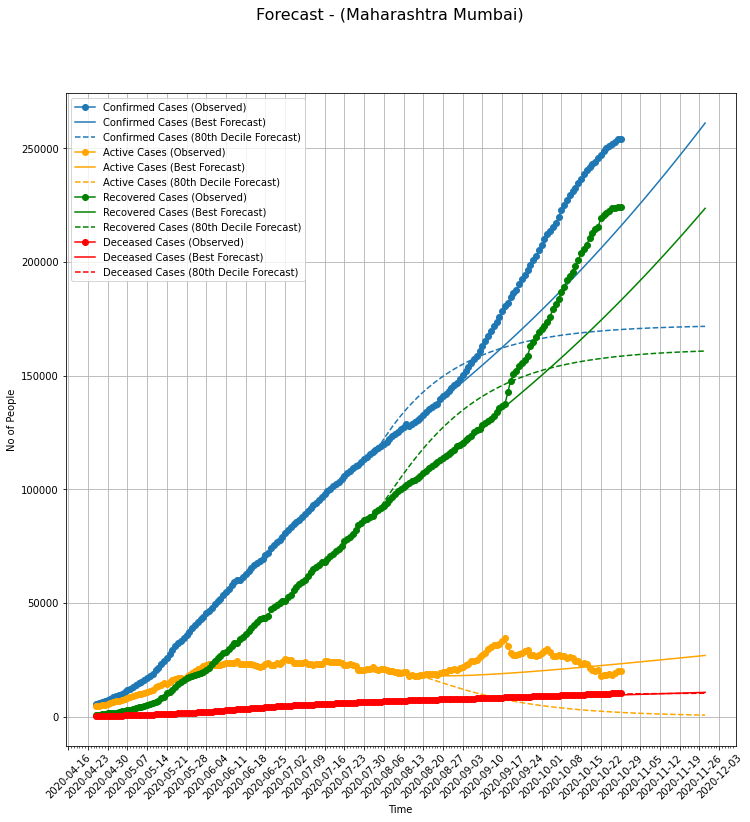

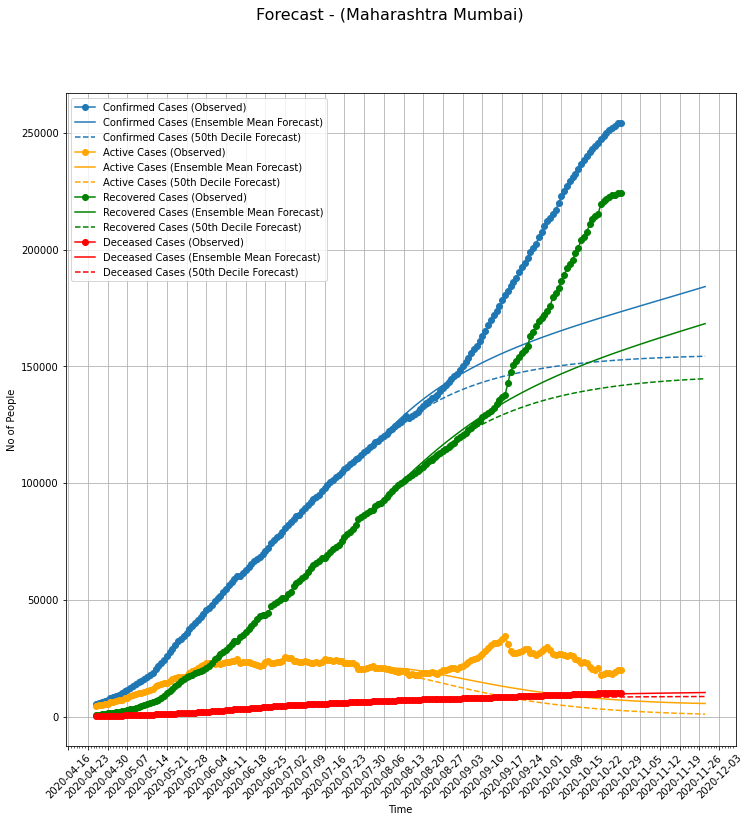

In [22]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

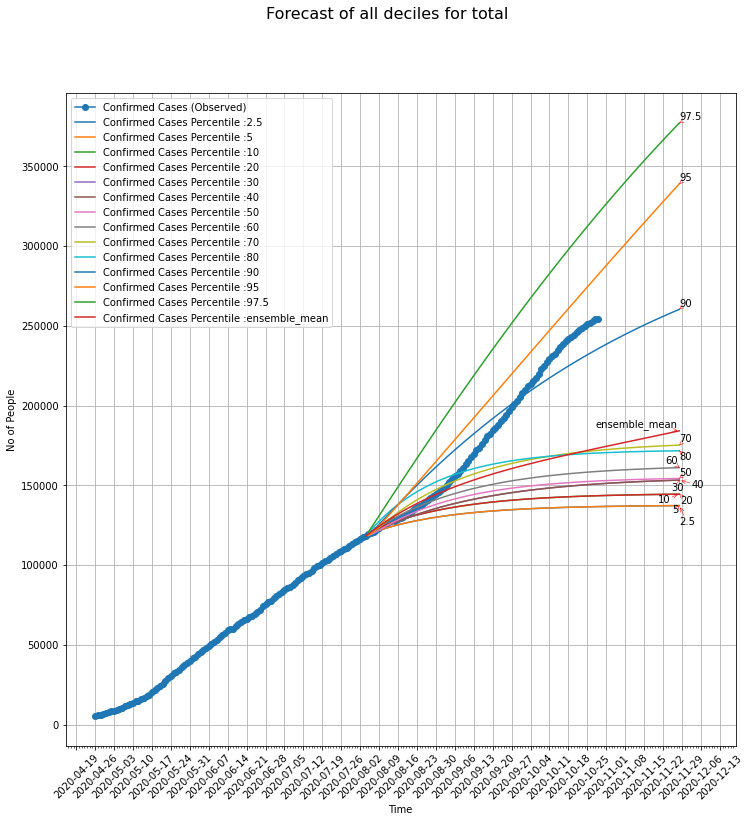

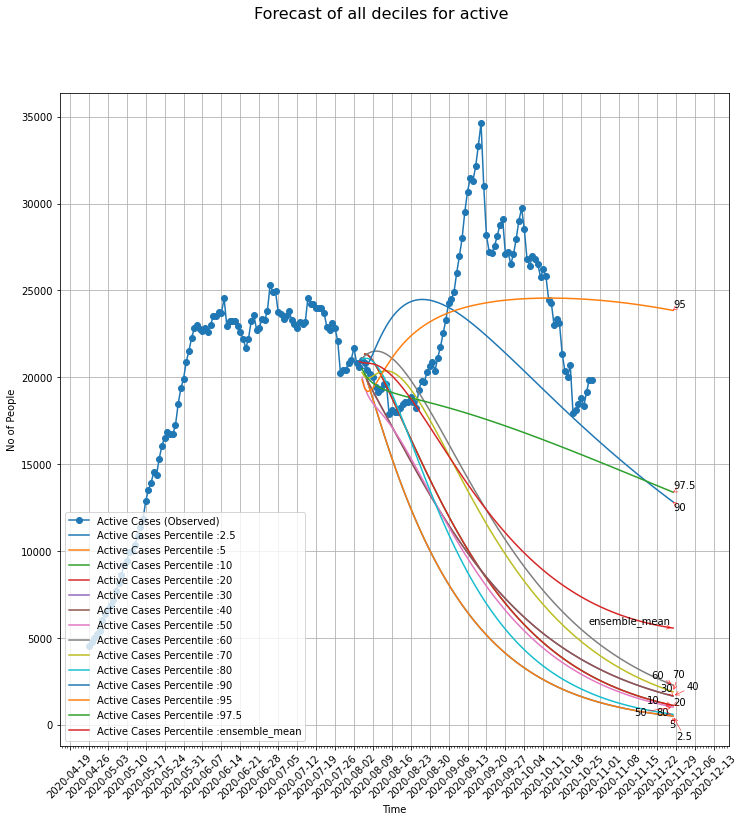

In [23]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


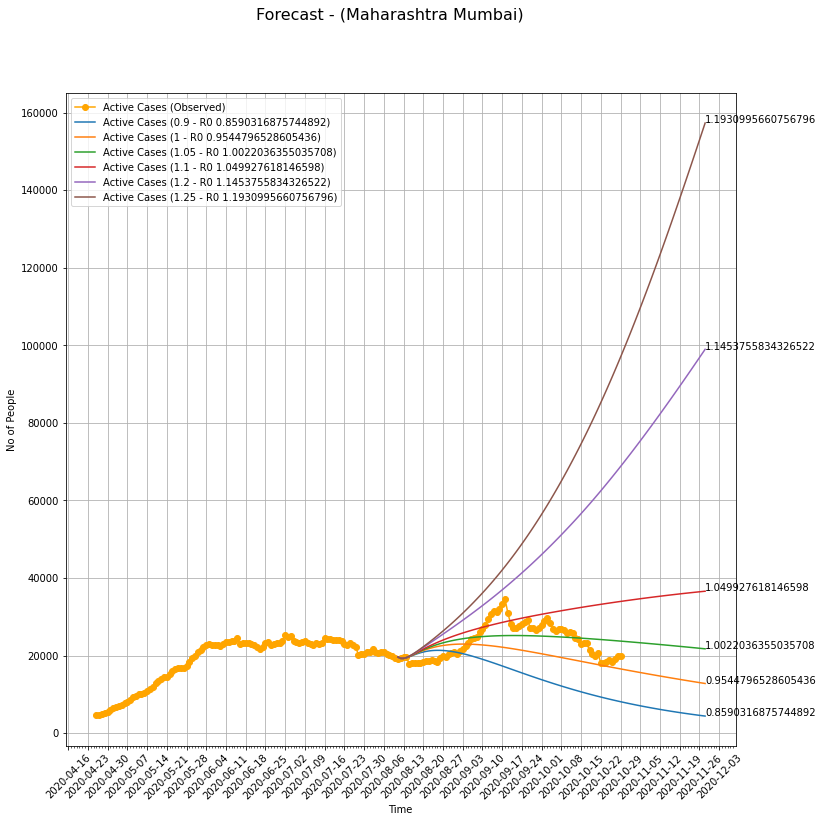

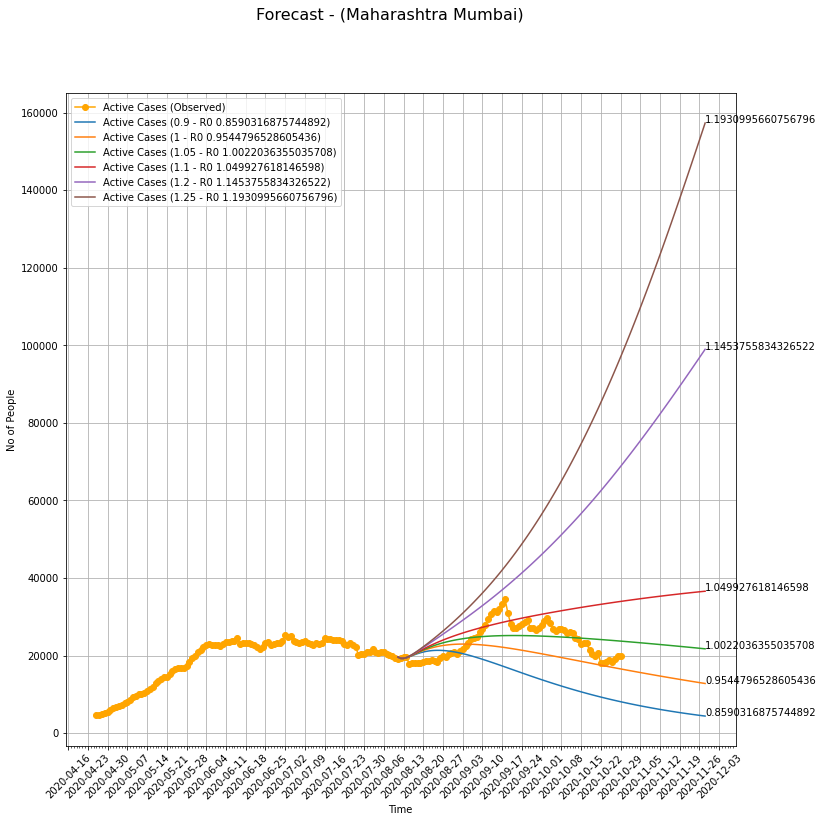

In [24]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_dict['m2']['r0_mul_dict'] = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
predictions_dict['m2']['plots']['r0_mul_dict'] = plot_r0_multipliers(predictions_dict, None, predictions_dict['m2']['r0_mul_dict'], None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [27]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

KeyError: 'r0_mul_dict'

## Create Output

In [26]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [27]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [28]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [29]:
save_r0_mul(predictions_dict['m2']['r0_mul_dict'], output_folder)

## Create df_district Output

In [30]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')